<a href="https://colab.research.google.com/github/hxtruong/greatmaps-vietbando/blob/master/notebook/%5BVietBanDo%5D_Connecting_reduced_gps_to_road_map_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import random
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
%time

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 26 µs


In [0]:
link = "https://raw.githubusercontent.com/hxtruong/greatmaps-vietbando/master/notebook/gps1.csv"
# Note: set param encoding = 'latin1'
df = pd.read_csv(link,encoding='utf-8')

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 7 columns):
vehicle        50000 non-null object
datetime       50000 non-null object
speed          50000 non-null float64
longitude      50000 non-null float64
latitude       50000 non-null float64
heading        50000 non-null float64
vehicleType    50000 non-null int64
dtypes: float64(4), int64(1), object(2)
memory usage: 2.7+ MB


In [0]:
df.describe()

,speed,longitude,latitude,heading,vehicleType
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,6.210833,106.684752,10.764112,122.889811,160.030000
std,10.176225,0.001809,0.006092,126.473069,219.622321
min,0.000000,106.681670,10.753520,-176.000000,0.000000
25%,0.000000,106.683220,10.759600,0.000000,0.000000
50%,0.000000,106.684616,10.763331,126.000000,0.000000
75%,11.000000,106.686500,10.768530,207.000000,300.000000
max,62.000000,106.687767,10.775833,12342.000000,900.000000


In [0]:
df.head(10)

,vehicle,datetime,speed,longitude,latitude,heading,vehicleType
0,51A74766,2019-01-08 15:19:56,9.0,106.681670,10.765310,106.2,0
1,51A74766,2019-01-08 15:27:13,11.0,106.681670,10.765380,0.0,300
2,51A07937,2019-01-08 15:27:55,0.0,106.681670,10.766630,328.0,0
3,51A07937,2019-01-08 15:32:54,6.0,106.681670,10.774990,50.0,0
4,51A07937,2019-01-08 16:07:29,17.0,106.681671,10.760513,254.0,200
5,51A07937,2019-01-08 16:12:30,5.0,106.681671,10.765172,-1.0,300
6,51A74766,2019-01-08 16:24:19,7.0,106.681671,10.765260,72.0,300
7,51B25820,2019-01-08 22:40:09,6.0,106.681671,10.765558,272.0,0
8,51B25820,2019-01-08 22:45:09,10.0,106.681671,10.765632,284.0,0
9,51A07937,2019-01-08 16:27:29,0.0,106.681671,10.766555,312.0,0


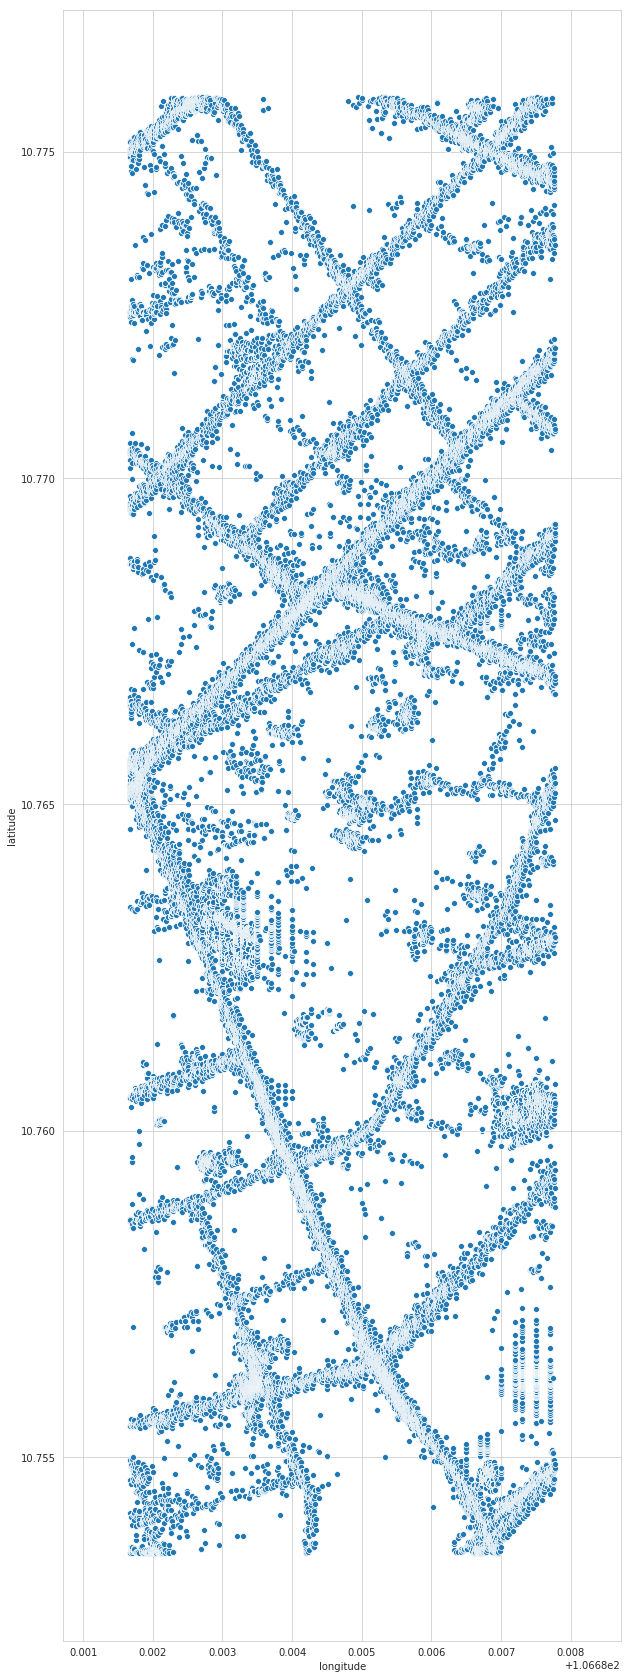

In [0]:
fig = plt.figure(figsize=(10, 30))
sns.scatterplot(x='longitude', y='latitude', data=df)
plt.show()

# DBSCAN 

In [0]:
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
from shapely.geometry import MultiPoint
import time
%matplotlib inline

In [0]:
# define the number of kilometers in one radian
kms_per_radian = 6371.0088

In [0]:
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)

In [0]:
# %xmode
%time
def dbscan_reduce(df, epsilon, x='longitude', y='latitude'):
    start_time = time.time()
    # represent points consistently as (lat, lon) and convert to radians to fit using haversine metric
    coords = df[[y,x]].to_numpy()    
    db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))

    cluster_labels = db.labels_
    num_clusters = len(set(cluster_labels))
    print('Number of clusters: {:,}'.format(num_clusters))
    
    clusters = pd.Series([coords[cluster_labels==n] for n in range(num_clusters)])
    
    # find the point in each cluster that is closest to its centroid
    centermost_points = clusters.map(get_centermost_point)

    # unzip the list of centermost points (lat, lon) tuples into separate lat and lon lists
    lats, lons = zip(*centermost_points)
    rep_points = pd.DataFrame({x:lons, y:lats})
    rep_points.tail()
    
    # pull row from original data set where lat/lon match the lat/lon of each row of representative points
    rs = rep_points.apply(lambda row: df[(df[y]==row[y]) & (df[x]==row[x])].iloc[0], axis=1)
    
    # all done, print outcome
    message = 'Clustered {:,} points down to {:,} points, for {:.2f}% compression in {:,.2f} seconds.'
    print(message.format(len(df), len(rs), 100*(1 - float(len(rs)) / len(df)), time.time()-start_time))    
    return rs

CPU times: user 0 ns, sys: 3 µs, total: 3 µs
Wall time: 8.11 µs


In [0]:
# first cluster the full gps location history data set coarsely, with epsilon=5km in radians
eps_rad = 0.002 / kms_per_radian
df_clustered = dbscan_reduce(df, epsilon=eps_rad)
df_final = df_clustered

Number of clusters: 15,524
Clustered 50,000 points down to 15,524 points, for 68.95% compression in 41.50 seconds.


In [0]:
# next, sample every nth row (where n=sample_rate) of the full gps location history data set
sample_rate = 20
df_sampled = df.iloc[range(0, len(df), sample_rate)]
len(df_sampled)

2500

In [0]:
# combine the clustered and sampled sets
df_combined = pd.concat([df_clustered, df_sampled], axis=0)
df_combined = df_combined.reset_index().drop(labels='index', axis=1)

In [0]:
# then reduce by clustering again, finely this time with epsilon=0.1km in radians
eps_rad = 0.001 / kms_per_radian
df_final = dbscan_reduce(df_combined, epsilon=eps_rad)

Number of clusters: 6,709
Clustered 7,371 points down to 6,709 points, for 8.98% compression in 14.80 seconds.


In [0]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15524 entries, 0 to 15523
Data columns (total 7 columns):
vehicle        15524 non-null object
datetime       15524 non-null object
speed          15524 non-null float64
longitude      15524 non-null float64
latitude       15524 non-null float64
heading        15524 non-null float64
vehicleType    15524 non-null int64
dtypes: float64(4), int64(1), object(2)
memory usage: 849.0+ KB


### Visulize

In [0]:
# # show a map of the worldwide data points
# %%time
# fig, ax = plt.subplots(figsize=[20,25])
# rs_scatter = ax.scatter(df_final['longitude'], df_final['latitude'], c='blue', edgecolor='None', alpha=0.3, s=120)
# df_scatter = ax.scatter(df['longitude'], df['latitude'], c='k', alpha=0.5, s=3)
# ax.set_title('Full data set vs DBSCAN reduced set')
# ax.set_xlabel('Longitude')
# ax.set_ylabel('Latitude')
# ax.legend([df_scatter, rs_scatter], ['Full set', 'Reduced set'], loc='upper right')
# plt.show()

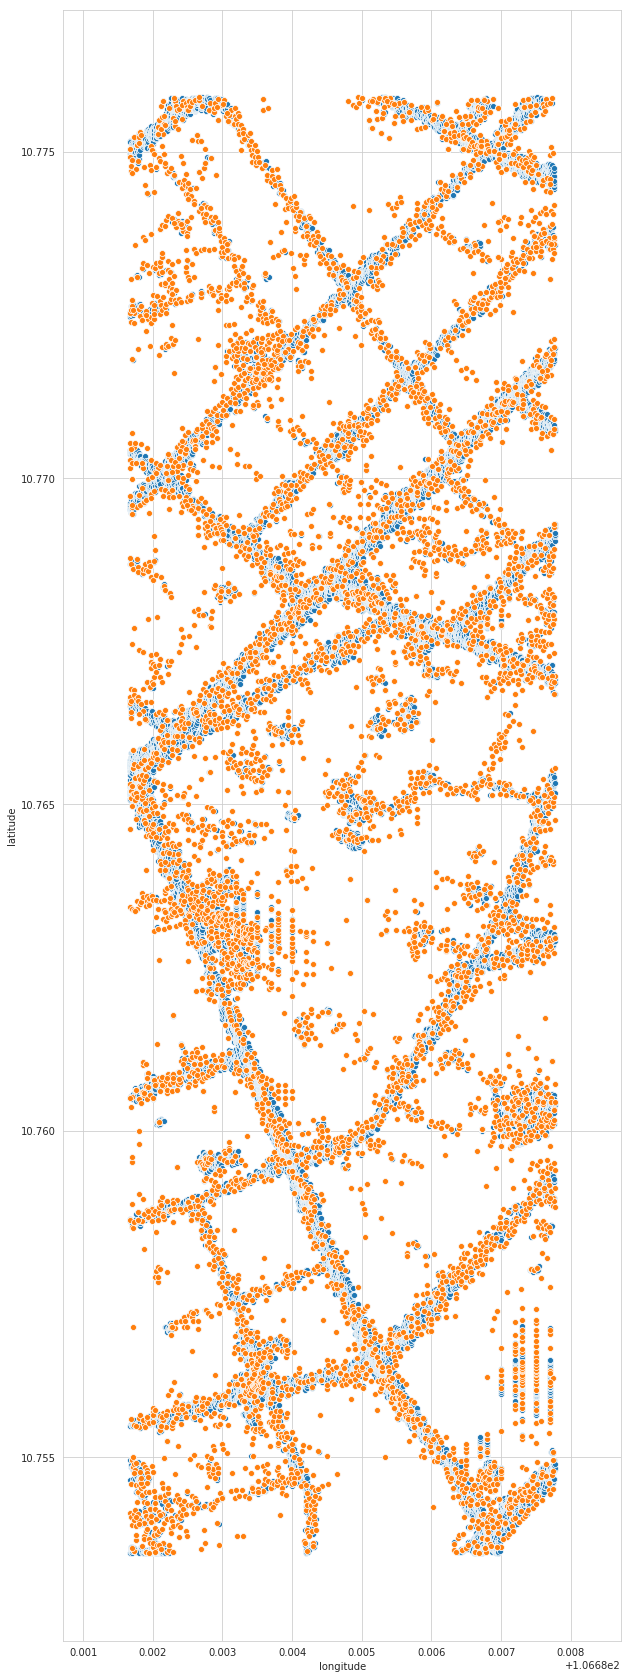

In [0]:
fig = plt.figure(figsize=(10, 30))
sns.scatterplot(x='longitude', y='latitude', data=df)
sns.scatterplot(x='longitude', y='latitude', palette="Set2", data=df_final )
plt.show()

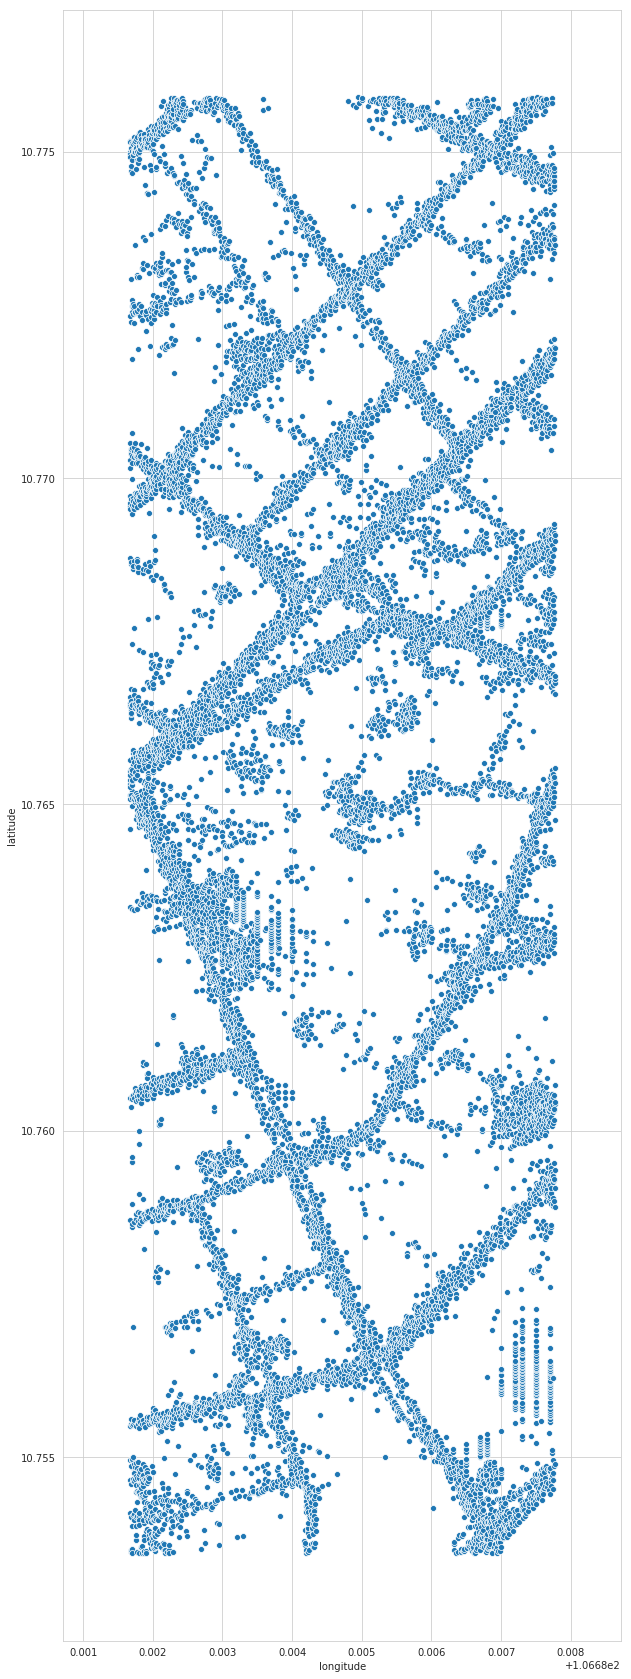

In [0]:
fig = plt.figure(figsize=(10, 30))
# sns.scatterplot(x='longitude', y='latitude', data=df)
sns.scatterplot(x='longitude', y='latitude', data=df_final )
plt.show()

### Create trip

In [0]:
df2 = df_final

In [0]:
from sklearn.metrics.pairwise import haversine_distances
from geopy.distance import great_circle

In [0]:
def distance(latln1, latln2):
    return great_circle(latln1, latln2).meters

In [0]:
from math import radians, cos, sin, asin, sqrt

def haversine(latln1, latln2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    lat1, lon1 = latln1
    lat2, lon2 = latln2
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    kms_per_radian = 6371.0088 # Radius of earth in kilometers. Use 3956 for miles
    return c * kms_per_radian

In [0]:
from scipy.spatial import  KDTree
coords = df2[['latitude', 'longitude']].to_numpy()
kdtree = KDTree(coords, leafsize=100000)

In [0]:
DIS_LIMIT = 20.0 #meters

In [0]:
%%time
trips = []
tripsLen = []
check =  [False for i in range(len(coords))]

i = 0
n = len(coords)
while i<n:
    while i < n and check[i]:
        i=i+1
    if i <n:
        check[i] = True
        trips.append([coords[i]])
       
        j = i
        while j < n:
            disRes, idxRes = kdtree.query(coords[j], k = 2000)
            nextJ = -1
            for idx in idxRes:
                if check[idx]:
                    continue
                dis = distance(coords[j], coords[idx])
                if dis>DIS_LIMIT:
                    break
                # print(j, '-> ',idx, ' : ', dis)
                check[idx] = True
                trips[len(trips)-1].append(coords[idx])
                nextJ = idx
                break
            if nextJ == -1:
                break
            j = nextJ
        # print('Trip #', i, ': ')
        # print('\tLength: ', len(trips[len(trips)-1]))
        tripsLen.append(len(trips[len(trips)-1]))
    else:
        break

CPU times: user 4min 30s, sys: 9.69 ms, total: 4min 30s
Wall time: 4min 31s


In [0]:
s = pd.Series(tripsLen) 
s.describe()

count    710.000000
mean      21.864789
std       53.631389
min        1.000000
25%        1.000000
50%        3.000000
75%       14.000000
max      631.000000
dtype: float64

### Draw

In [0]:
# !pip install gmplot

In [0]:
from gmplot import gmplot
import webbrowser, os, json

In [0]:
MIN_LENGTH_TRIP = 20

In [0]:
# Place map
gmap = gmplot.GoogleMapPlotter(coords[0][0], coords[0][1], 15)

# Scatter points
for trip in trips:
    # print("Lenth: ", len(trip))
    if len(trip)<MIN_LENGTH_TRIP:
        continue
    lats, lons = zip(*trip)
    color = "#{:06x}".format(random.randint(0, 0xFFFFFF))
    # gmap.scatter(lats, lons, color , size=5, marker=False)
    gmap.plot(lats, lons, color, edge_width=2)
    
# Draw
gmap.draw("my_map.html")

In [0]:
filename = 'file:///'+os.getcwd()+'/' + 'my_map.html'
webbrowser.open_new_tab('./my_map.html')

False